In [272]:
import networkx as nx
from itertools import product
from typing import List, Tuple, Dict
import json
import random

import sympy as sp
import numpy as np

In [644]:
# given an expr string that can be evaluated with sympy
# return the derivative as a lambda function
def get_derivative_function(expression_str, variable='x'):    
    # define variable, parse expression
    x = sp.symbols(variable)
    expression = sp.sympify(expression_str)
    
    # differentiate expression w.r.t. x
    derivative_expr = sp.diff(expression, x)

    # convert derivative to python function
    derivative_func = sp.lambdify(x, derivative_expr, 'numpy')

    # print original + derivative for verifications purposes
    print(f"Original expression: {expression}")
    print(f"Derivative: {derivative_expr}")
    
    return derivative_func

In [31]:
def json_to_atomic_instance(graph_json, verbose=False):
    if isinstance(graph_json, str):
        with open(graph_json) as f:
            graph = json.load(f)
    elif not isinstance(graph_json, dict):
        raise Exception('Invalid graph json type. Either requires string of a filename or a json object')
    id_to_label = {}
    for node in graph['nodes']:
        if verbose:
            print(node)
        id_to_label[node['id']] = node['label']
    G = nx.DiGraph()
    latency_functions = {}
    for edge in graph['edges']:
        from_node = id_to_label[edge['from']]
        to_node = id_to_label[edge['to']]
        G.add_edge(from_node, to_node)

        f1 = eval('lambda x: ' + edge['latencyFunction'])
        # f2 = get_derivative_function(edge['latencyFunction'], variable='x')
        latency_functions[(from_node, to_node)] = f1
    source_sink_pairs = []
    demands = []
    for source_sink_pair in graph['sourceSinkPairs']:
        source_node = id_to_label[source_sink_pair['source']]
        sink_node = id_to_label[source_sink_pair['sink']]
        demand = int(source_sink_pair['demand'])
        source_sink_pairs.append((source_node, sink_node))
        demands.append(demand)
        
    nx.draw_networkx(G)
    if verbose:
        print(latency_functions)
    return (G, source_sink_pairs, demands, latency_functions)

In [645]:
# Testing get_derivative_function
assert(get_derivative_function('x**2 + 2*x')(2) == 6)
assert(get_derivative_function('2*x**4 + 4*x**3 + 5')(3) == 324)

Original expression: x**2 + 2*x
Derivative: 2*x + 2
Original expression: 2*x**4 + 4*x**3 + 5
Derivative: 8*x**3 + 12*x**2


In [16]:
def get_strategy_sets(G, source_sink_pairs):
    # index represents a player (e.g., index 0 = player 0)
    # value represents a list of paths the player can take from their source to their sink
    paths = []

    # Initialize paths array for each player
    # idx represents the player, (s, t) represents that player's associated commodity
    for idx, (s, t) in enumerate(source_sink_pairs):
        simple_paths = list(nx.all_simple_paths(G, s, t))
        paths.append(simple_paths)

    return paths

In [569]:
# paths: each index represents a player, the value at that index represents that player's available strategy set (ordered)
# flow: each index represents a player, the value at that index represents the player's choice of strategy (as an index of their strategy set)
# demands: each index represents a player, the value at that index represents how many units of traffic that player is routing

# return a dictionary of edge flows, an array of player latencies, and the total latency across all players
def calculate_edge_flows(paths, flow, demands, latency_functions):
    f_e = {}  # Edge flows. key is an edge (represented as a tuple between 2 vertices), value is the flow (units of traffic on that edge)
    # go through each player and their choice of path

    player_latencies = [0 for _ in range(len(flow))]
    
    for player_idx, path_idx in enumerate(flow): # go thru each player and their chosen path
        path = paths[player_idx][path_idx] # get the path that the player is taking
        demand = demands[player_idx]
        
        for i in range(len(path) - 1): # route through that player's path
            edge = (path[i], path[i + 1])
            f_e[edge] = f_e.get(edge, 0) + demand # update the congestion for this edge

    for player_idx in range(len(player_latencies)): # go through each player
        path_idx = flow[player_idx]
        current_path = paths[player_idx][path_idx]
        current_latency = 0
        for i in range(len(current_path) - 1):
            edge = (current_path[i], current_path[i + 1])
            congestion = f_e[edge]
            edge_latency = latency_functions[edge](f_e[edge])
            current_latency += edge_latency
        player_latencies[player_idx] = current_latency
    total_latency = sum(player_latencies)
    return f_e, player_latencies, total_latency

In [55]:
# paths: each index represents a player, the value at that index represents that player's available strategy set (ordered)
# flow: each index represents a player, the value at that index represents the player's choice of strategy (as an index of their strategy set)
# demands: each index represents a player, the value at that index represents how many units of traffic that player is routing

# return a dictionary of edge flows, an array of player latencies, and the total latency across all players
# TODO: fix
def calculate_edge_flows_with_taxes(paths, flow, demands, latency_functions):
    f_e = {}  # Edge flows. key is an edge (represented as a tuple between 2 vertices), value is the flow (units of traffic on that edge)
    # go through each player and their choice of path

    player_latencies = [0 for _ in range(len(flow))]
    for player_idx, path_idx in enumerate(flow):
        path = paths[player_idx][path_idx] # get the path that the player is taking
        demand = demands[player_idx]
        player_latency = 0
        
        for i in range(len(path) - 1):
            edge = (path[i], path[i + 1])
            f_e[edge] = f_e.get(edge, 0) + demand # get the flow for this edge
            player_latencies[player_idx] += latency_functions[edge](f_e[edge]) # update the current player's latency
    total_latency = sum(player_latencies)
    return f_e, player_latencies, total_latency

In [652]:
def brute_force(G: nx.DiGraph, source_sink_pairs: List[Tuple[int, int]], demands: List[int], latency_functions: Dict):
    # each player's strategy set is represented as a set of available paths from their source to their sink
    paths = get_strategy_sets(G, source_sink_pairs)

    # flow: index represents a player (player 0 = source_sink_pair[0], etc)
    # value represents an path index for that player
    min_total_latency = float('inf')
    best_flow = None # best flow is the one that minimizes total latency

    # map a flow tuple to a map detailing the latency each player suffers in the flow
    # key: flow tuple, value: map of player : player_latency
    equil_lookup = {}

    # list of all flow tuples (need tuples for map lookup)
    # TODO: calculate product(...) and store in all_flows directly, rather than building all_flows one by one
    all_flows = []
    
    for flow in product(*[[i for i in range(len(path))] for idx, path in enumerate(paths)]):
        total_latency = 0
        flow_tuple = tuple(flow)
        all_flows.append(flow_tuple)
        f_e = {} # store the amount of traffic that uses any given edge in this flow

        print('*' * 8, flow, '*' * 8)

        # calculate how much flow each edge has, store in f_e
        for player, path_idx in enumerate(flow):
            path = paths[player][path_idx]
            print('player {}: path {}'.format(player, paths[player][path_idx]))
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                if edge in f_e:
                    f_e[edge] += demands[player]
                else:
                    f_e[edge] = demands[player]
        print(f_e)

        # calculate the sum of each player's latency in this flow
        for player, path_idx in enumerate(flow):
            path = paths[player][path_idx]
            player_latency = 0
            # print('player {}: path {}'.format(player, paths[player][path_idx]))
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                edge_latency = latency_functions[edge](f_e[edge])
                total_latency += edge_latency
                player_latency += edge_latency
            if flow_tuple not in equil_lookup:
                equil_lookup[flow_tuple] = {player : player_latency}
            else:
                equil_lookup[flow_tuple][player] = player_latency
                
        print(total_latency)

        # update optimal flow if it exists
        if total_latency <= min_total_latency:
            min_total_latency = total_latency
            best_flow = flow


    # store list of equil flows, each of which is represented by a tuple
    equil_flows = []
    
    # iterate through each flow, check if each one is an equilibrium flow
    for flow in all_flows:
        is_equil = True
        for player in range(len(flow)):
            curr_latency = equil_lookup[flow][player]
            for path_idx in range(len(paths[player])):
                flow_list = list(flow)
                flow_list[player] = path_idx
                new_flow = tuple(flow_list)
                if new_flow in equil_lookup:
                    # could've done better by deviating
                    if equil_lookup[new_flow][player] < curr_latency: 
                        is_equil = False
                        break
        if is_equil:
            print('FOUND EQUILIBIRUM FLOW', flow)
            equil_flows.append(flow)
    
    print('*' * 30)
    # print out the best path for each player
    for player, path_idx in enumerate(best_flow):
        print('player {}: path {}'.format(player, paths[player][path_idx]))
    return paths, equil_flows, best_flow, min_total_latency


In [649]:
# TODO: fix
def brd_alg(
    G: nx.DiGraph,
    source_sink_pairs: List[Tuple[int, int]],
    demands: List[int],
    latency_functions: Dict,
    max_iterations: int = 1000,
    marginal_cost_pricing: bool = False
):
    # each player's strategy set is represented as a set of available paths from their source to their sink
    paths = get_strategy_sets(G, source_sink_pairs)

    num_players = len(source_sink_pairs)

    # for each player, initialize to 0th strategy (TODO: maybe initialize random)
    current_flow = [0 for _ in range(num_players)]

    converged = False
    iteration = 0

    while not converged and iteration < max_iterations:
        converged = True # assume convergence unless we find a player that wants to change their strategy
        iteration += 1

        f_e, player_latencies, total_latency = calculate_edge_flows(paths, current_flow, demands, latency_functions)

        # for each player, try to see if they can improve their latency by switching paths
        for player_idx in range(num_players):
            current_latency = player_latencies[player_idx]
            current_path_idx = current_flow[player_idx]
            current_path = paths[player_idx][current_path_idx]

            # assume for now that we are picking the best response, but this may update if we find something better
            best_latency = current_latency
            best_path_idx = current_path_idx

            for alternative_path_idx, alternative_path in enumerate(paths[player_idx]):
                if alternative_path_idx == current_path_idx:
                    continue
                hypothetical_f_e = f_e.copy()
                demand = demands[player_idx]

                # Remove player's demand from the paths edges they are currently using
                for i in range(len(current_path) - 1):
                    edge = (current_path[i], current_path[i + 1])
                    hypothetical_f_e[edge] -= demand

                # Add player's demand to alternative path edges
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    hypothetical_f_e[edge] = hypothetical_f_e.get(edge, 0) + demand

                # Compute latency for the alternative path
                alternative_latency = 0
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    flow = hypothetical_f_e[edge]
                    edge_latency = latency_functions[edge](flow)
                    alternative_latency += edge_latency

                # If the alternative latency is better, update best response
                if alternative_latency < best_latency:
                    best_latency = alternative_latency
                    best_path_idx = alternative_path_idx

            # If the best path is different from current, update player's path and set converged to False
            if best_path_idx != current_path_idx:
                current_flow[player_idx] = best_path_idx
                converged = False
                break # found a player who can do better, update that player and try BRD again!

        if iteration >= max_iterations:
            print('reached max iterations')
            
        # at the end, we should've made enough changes to current_flow s.t. it's an equilibrium flow
        f_e, player_latencies, total_latency = calculate_edge_flows(paths, current_flow, demands, latency_functions)

    # paths: strategy sets for each player
    # current_flow: the equilibrium flow. each idx represents a player, each value represents the strategy that the player picked (ex: strategy 0, 1, ...)
    # player_latencies: the latency of each player in the equilibrium flow
    # total latency: sum of player latencies
    return paths, current_flow, player_latencies, total_latency

In [654]:
def braess_paradox_bruteforce():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, equil_flow, best_flow, min_total_latency = brute_force(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flow)
    print('best flow: ', best_flow)
    print('Minimum total latency: ', min_total_latency)

******** (0, 0) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 2, ('v', 't'): 2}
8
******** (0, 1) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 'w', 't']
{('s', 'v'): 2, ('v', 't'): 1, ('v', 'w'): 1, ('w', 't'): 1}
7
******** (0, 2) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'w', 't']
{('s', 'v'): 1, ('v', 't'): 1, ('s', 'w'): 1, ('w', 't'): 1}
6
******** (1, 0) ********
player 0: path ['s', 'v', 'w', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 2, ('v', 'w'): 1, ('w', 't'): 1, ('v', 't'): 1}
7
******** (1, 1) ********
player 0: path ['s', 'v', 'w', 't']
player 1: path ['s', 'v', 'w', 't']
{('s', 'v'): 2, ('v', 'w'): 2, ('w', 't'): 2}
8
******** (1, 2) ********
player 0: path ['s', 'v', 'w', 't']
player 1: path ['s', 'w', 't']
{('s', 'v'): 1, ('v', 'w'): 1, ('w', 't'): 2, ('s', 'w'): 1}
7
******** (2, 0) ********
player 0: path ['s', 'w', 't']
player 1: path ['s', 'v', 't']
{('s', 'w'): 1, ('w', 't'): 1, ('

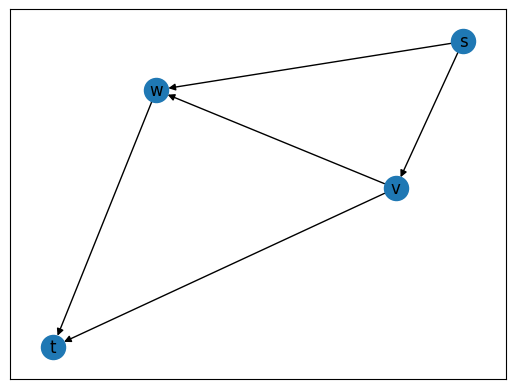

In [655]:
braess_paradox_bruteforce()

In [650]:
def braess_paradox_brd():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, equil_flow, player_latencies, min_total_latency = brd_alg(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('player latencies: ', player_latencies)
    print('Equilibrium flows: ', equil_flow)
    print('Minimum total latency: ', min_total_latency)

All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
player latencies:  [3, 4]
Equilibrium flows:  [1, 0]
Minimum total latency:  7


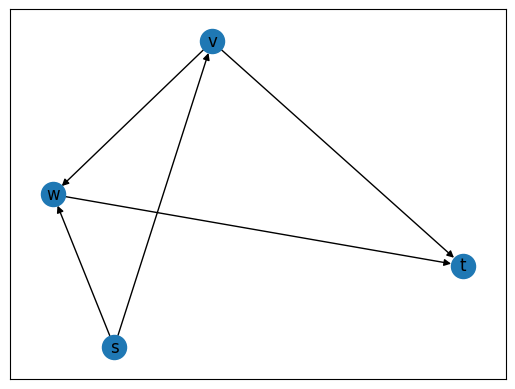

In [651]:
braess_paradox_brd()

In [570]:
def AAE_brd():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/aae_example.txt')
    paths, equil_flow, player_latencies, min_total_latency = brd_alg(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('player latencies: ', player_latencies)
    print('Equilibrium flows: ', equil_flow)
    print('Minimum total latency: ', min_total_latency)

All paths:  [[['u', 'v'], ['u', 'w', 'v']], [['u', 'v', 'w'], ['u', 'w']], [['v', 'u', 'w'], ['v', 'w']], [['w', 'v'], ['w', 'u', 'v']]]
player latencies:  [1, 1, 1, 1]
Equilibrium flows:  [0, 1, 1, 0]
Minimum total latency:  4


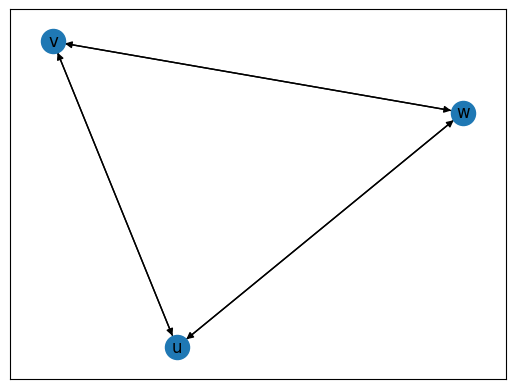

In [571]:
AAE_brd()

In [640]:
def no_equil_brd():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/no_equil.txt')
    paths, equil_flow, player_latencies, min_total_latency = brd_alg(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('player latencies: ', player_latencies)
    print('Equilibrium flows: ', equil_flow)
    print('Minimum total latency: ', min_total_latency)

reached max iterations
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']]]
player latencies:  [47, 60]
Equilibrium flows:  [2, 0]
Minimum total latency:  107


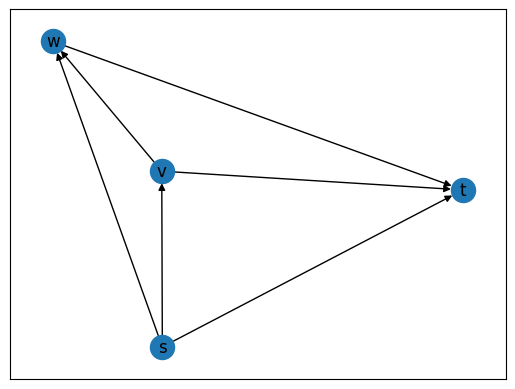

In [641]:
no_equil_brd()

In [195]:
# given a list of values, return the softmax vector
def softmax(values):
    exp_values = np.exp(values - np.max(values))  # Shift for numerical stability
    return exp_values / np.sum(exp_values)

In [196]:
def sample_move(probabilities):
    # sample a move based on a probablity distribution
    return np.random.choice(len(probabilities), p=probabilities)

In [324]:
def sample_move_skip_index(probabilities, skip_index):
    """
    Sample a move based on a probability distribution, skipping the specified index.

    Parameters:
    - probabilities: List or numpy array of probabilities for each index.
    - skip_index: Index to skip during sampling.

    Returns:
    - Selected index, excluding the skipped index.
    """
    probabilities = np.array(probabilities)  # Ensure input is a numpy array
    adjusted_probs = np.delete(probabilities, skip_index)  # Remove skipped index
    adjusted_probs /= adjusted_probs.sum()  # Normalize probabilities

    # Sample from the adjusted probabilities
    sampled_index = np.random.choice(len(adjusted_probs), p=adjusted_probs)
    
    # Map back to the original index
    return sampled_index if sampled_index < skip_index else sampled_index + 1

In [197]:
# logits: list of logits for the player's strategies
# feedback: feedback for the chosen move
# chosen_idx: index of the chosen move
# learning rate: step size for updating the logit
def update_logits(logits, feedback, chosen_idx, learning_rate=1):
    logits[chosen_idx] += learning_rate * feedback
    return logits

In [648]:
def mixed2(
    G: nx.DiGraph,
    source_sink_pairs: List[Tuple[int, int]],
    demands: List[int],
    latency_functions: Dict,
    max_iterations: int = 1000,
    learning_rate = .1,
    verbose = False
):
    # each player's strategy set is represented as a set of available paths from their source to their sink
    paths = get_strategy_sets(G, source_sink_pairs)
    num_players = len(source_sink_pairs)

    # start with no bias for any particular strategy
    logits = [np.array([1.0 for _ in range(len(player_path))]) for player_path in paths]

    # for each player, initialize to random strategy
    random.seed(10)
    current_flow = [random.randint(0, len(paths[player_idx]) - 1) for player_idx in range(num_players)]

    if verbose:
        print('paths ', paths)
        print('starting flow ', current_flow)
        
    iteration = 0

    # debugging information, to make sure players are picked uniformly at random
    picked_players = [0 for _ in range(num_players)]
    
    while iteration < max_iterations:
        
        if verbose:
            print('-' * 8, 'starting round: ', iteration, '-' * 8)
        iteration += 1

        # previous flows, latencies

        # TODO: can we reduce the amount of times this calculation is called so it's more efficient?
        f_e, player_latencies, total_latency = calculate_edge_flows(paths, current_flow, demands, latency_functions)
        player_idx = random.randint(0, num_players - 1) # pick a random player
        picked_players[player_idx] += 1

        # get previous latency/path
        prev_latency = player_latencies[player_idx]
        prev_path_idx = current_flow[player_idx]
        prev_path = paths[player_idx][prev_path_idx]
        
        # construct a new flow
        mixed_strat = softmax(logits[player_idx]) # get a player's mixed strategy from their logits

        # even if we were at the best move, and we pick a worse alternative
        # what would happen is that we would evaluate the alternative to be bad, lower its probability of happening
        # then maybe go back to the best, which by virtue of being the best, we would increase its probability of happening again
        # this way, good moves get rewarded, bad moves get punished probabilistically
        alternative_path_idx = sample_move_skip_index(mixed_strat, prev_path_idx) # pick some alternate move (no point of repeating current move)
        alternative_path = paths[player_idx][alternative_path_idx]

        # debugging information
        if verbose:
            print('picking player', player_idx)
            print('previous latency', prev_latency)
            print('prev path idx', prev_path_idx)
            print('alternative path idx', alternative_path_idx)
            print('alternative_path')

        # develop alternative path
        hypothetical_f_e = f_e.copy()
        demand = demands[player_idx]

        # constructing the alternative flow
        # step 1: Remove player's demand from the path's edges they are currently using
        for i in range(len(prev_path) - 1):
            edge = (prev_path[i], prev_path[i + 1])
            hypothetical_f_e[edge] -= demand

        # step 2: Add player's demand to alternative path edges
        for i in range(len(alternative_path) - 1):
            edge = (alternative_path[i], alternative_path[i + 1])
            hypothetical_f_e[edge] = hypothetical_f_e.get(edge, 0) + demand

        # step 3: Compute latency for the alternative path
        alternative_latency = 0
        for i in range(len(alternative_path) - 1):
            edge = (alternative_path[i], alternative_path[i + 1])
            congestion = hypothetical_f_e[edge]
            edge_latency = latency_functions[edge](congestion)
            alternative_latency += edge_latency

        # get difference between alternative utility and current utility
        # utility is -1 * latency
        # give logit a positive increase for good delta where alternative utility increased
        delta = -alternative_latency - (-prev_latency)

        # debugging data
        if verbose:
            print('delta', delta)
            print('old logits: ', logits[player_idx])

        # update logits. positive delta = alternative was good, and should be picked more frequently in the future
        logits[player_idx][alternative_path_idx] += learning_rate * delta

        # debugging data
        if verbose:
            print('new logits: ', logits[player_idx])

        current_flow[player_idx] = alternative_path_idx

    # get final mixed strategy profile
    probabilities_profile = [softmax(player_logits) for player_logits in logits]
    print(picked_players)
    # paths: strategy sets for each player
    # current_flow: the equilibrium flow. each idx represents a player, each value represents the strategy that the player picked (ex: strategy 0, 1, ...)
    # player_latencies: the latency of each player in the equilibrium flow
    # total latency: sum of player latencies
    return paths, probabilities_profile

In [596]:
def braess_paradox_mixed_2():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, probabilties_profile = mixed2(G, source_sink_pairs, demands, latency_functions, 10, .1, verbose=True)
    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

paths  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
starting flow  [2, 0]
-------- starting round:  0 --------
picking player 1
previous latency 3
prev path idx 0
alternative path idx 1
alternative_path
delta 0
old logits:  [1. 1. 1.]
new logits:  [1. 1. 1.]
-------- starting round:  1 --------
picking player 1
previous latency 3
prev path idx 1
alternative path idx 0
alternative_path
delta 0
old logits:  [1. 1. 1.]
new logits:  [1. 1. 1.]
-------- starting round:  2 --------
picking player 0
previous latency 3
prev path idx 2
alternative path idx 1
alternative_path
delta 0
old logits:  [1. 1. 1.]
new logits:  [1. 1. 1.]
-------- starting round:  3 --------
picking player 0
previous latency 3
prev path idx 1
alternative path idx 0
alternative_path
delta -1
old logits:  [1. 1. 1.]
new logits:  [0.9 1.  1. ]
-------- starting round:  4 --------
picking player 1
previous latency 4
prev path idx 0
alternative path idx 

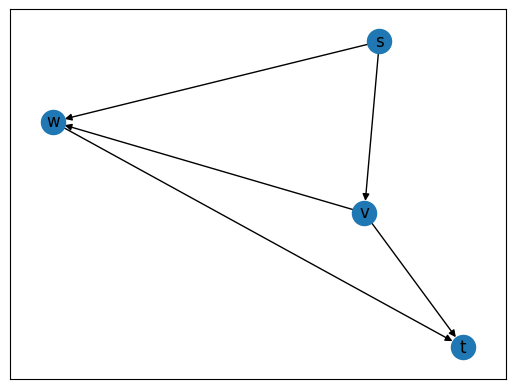

In [597]:
braess_paradox_mixed_2()

In [593]:
def AAE_mixed2():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/aae_example.txt')
    paths, probabilties_profile = mixed2(G, source_sink_pairs, demands, latency_functions, 1000, 1, verbose=False)
    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[246, 248, 233, 273]
All paths:  [[['u', 'v'], ['u', 'w', 'v']], [['u', 'v', 'w'], ['u', 'w']], [['v', 'u', 'w'], ['v', 'w']], [['w', 'v'], ['w', 'u', 'v']]]
Probabilities profile:  [array([1.000000e+000, 1.551878e-170]), array([4.11078858e-160, 1.00000000e+000]), array([3.09335001e-50, 1.00000000e+00]), array([1.00000000e+00, 2.74878501e-43])]


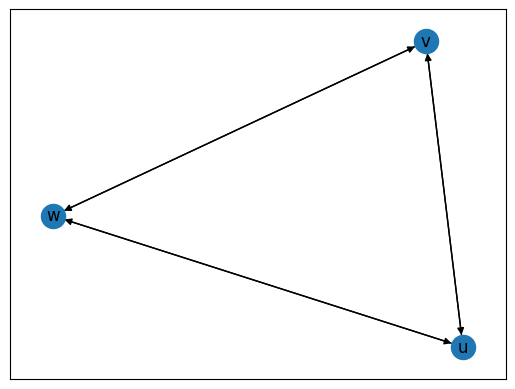

In [594]:
AAE_mixed2()

In [622]:
def braess_before_mixed_2():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_before.txt')
    paths, probabilties_profile = mixed2(G, source_sink_pairs, demands, latency_functions, 100000, .1, verbose=False)
    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[50144, 49856]
All paths:  [[['s', 'v', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([2.33154625e-18, 1.00000000e+00]), array([9.99996628e-01, 3.37200386e-06])]


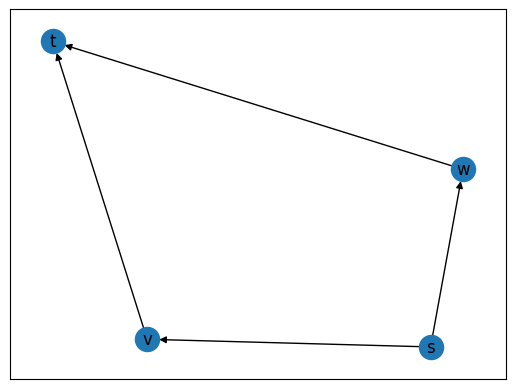

In [623]:
braess_before_mixed_2()

In [638]:
def no_equil_mixed2():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/no_equil.txt')
    paths, probabilties_profile = mixed2(G, source_sink_pairs, demands, latency_functions, 1000, 1, verbose=False)
    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[494, 506]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([3.39227019e-47, 1.80485139e-35, 1.00000000e+00, 4.07955867e-41]), array([1.49021879e-193, 6.94275967e-208, 1.39449056e-206, 1.00000000e+000])]


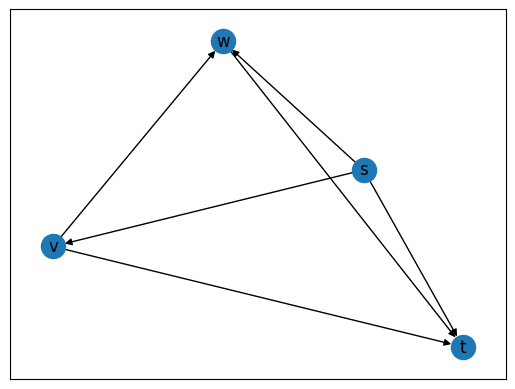

In [643]:
no_equil_mixed2()

In [656]:
def no_equil_bruteforce():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/no_equil.txt')
    paths, equil_flow, best_flow, min_total_latency = brute_force(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flow)
    print('best flow: ', best_flow)
    print('Minimum total latency: ', min_total_latency)

******** (0, 0) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 3, ('v', 't'): 3}
160
******** (0, 1) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 'w', 't']
{('s', 'v'): 3, ('v', 't'): 1, ('v', 'w'): 2, ('w', 't'): 2}
149
******** (0, 2) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 't']
{('s', 'v'): 1, ('v', 't'): 1, ('s', 't'): 2}
142
******** (0, 3) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'w', 't']
{('s', 'v'): 1, ('v', 't'): 1, ('s', 'w'): 2, ('w', 't'): 2}
109
******** (1, 0) ********
player 0: path ['s', 'v', 'w', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 3, ('v', 'w'): 1, ('w', 't'): 1, ('v', 't'): 2}
121
******** (1, 1) ********
player 0: path ['s', 'v', 'w', 't']
player 1: path ['s', 'v', 'w', 't']
{('s', 'v'): 3, ('v', 'w'): 3, ('w', 't'): 3}
240
******** (1, 2) ********
player 0: path ['s', 'v', 'w', 't']
player 1: path ['s', 't']
{('s', 'v'): 1, ('v', 'w'): 1, ('w', 't'): 1, 

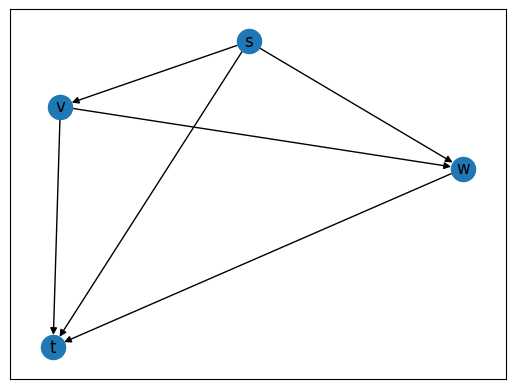

In [657]:
no_equil_bruteforce()